In [1]:
from module.Iris_recognition import *
from module.Periocular_recognition import *
from module.score_fusion import *
import os

In [2]:
# load the features from the file
with np.load('temp_data/features.npz') as data:
    features_train_a = data['features_train_a']
    features_train_b = data['features_train_b']
    y_train_final = data['label_train']
    img_label_train = data['img_label_train']
    
    features_test_a = data['features_test_a']
    features_test_b = data['features_test_b']
    y_test_final = data['label_test']
    img_label_test = data['img_label_test']

In [3]:
# load the features from the file
with np.load('temp_data/fusion_scores_enhanced.npz') as data:
    fusion_scores_train = data['fusion_scores_train']
    fusion_scores_test = data['fusion_scores_test']

In [4]:
import pickle
from sklearnex import patch_sklearn
patch_sklearn()
import sklearn.svm as svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
import logging

logger = logging.getLogger("sklearnex")
logger.setLevel(logging.WARNING)  # Set the logger's logging level to WARNING or higher

In [6]:
X_train_scaled, X_test_scaled = feature_preprocessing(features_train_a, features_test_a, features_train_b, features_test_b, fusion_scores_train, fusion_scores_test, use_fusion=True)

In [7]:
svm = pickle.load(open('model/svm_VGG16_fusion_enha.pickle', "rb"))

In [8]:
rfc = pickle.load(open('model/rfc_VGG16_fusion_enha.pickle', "rb"))

In [9]:
lr = pickle.load(open('model/lr_VGG16_fusion_enha.pickle', "rb"))

In [10]:
# # load the features from the file
# with np.load('temp_data/iris_norm_all.npz') as data:
#     iris_norm_L = data['iris_norm_L']
#     iris_norm_R = data['iris_norm_R']

In [11]:
# predict, ground_truth = accuracy_score_multi_thread(img_label_test, rfc, iris_norm_L, iris_norm_R, X_test_scaled)

In [12]:
predict, ground_truth = accuracy_score_preload(img_label_test, rfc, fusion_scores_test, X_test_scaled)

  0%|          | 0/4000 [00:00<?, ?it/s]

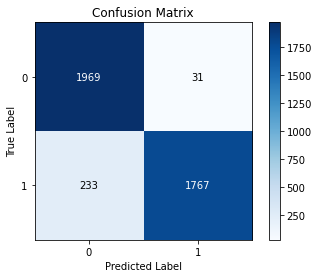

In [13]:
plot_confusion_matrix(ground_truth, predict)

In [14]:
print_accuracy(ground_truth, predict)

Accuracy: 0.93
Precision: 0.98
Recall: 0.88
F1 Score: 0.93
